# Left Bundle Branch Block

In [60]:
import os
import pdb

import matplotlib
matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import hilbert, periodogram
import wfdb

from bc.beats import get_beats, get_beat_bank
from bc.io import ann_to_df
from bc.preprocess import bandpass, normalize

base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data')

# Table of record names and the beat types they contain
beat_table = pd.read_csv(os.path.join(data_dir, 'beat-types.csv'), dtype={'record':object})
beat_table.set_index('record', inplace=True)

/home/cx1111/Software/pythonenvs/p35/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cx1111/Software/pythonenvs/p35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/cx1111/Software/pythonenvs/p35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/cx1111/Software/pythonenvs/p35/lib/python3.5/site-packages/ipykernel/kernelapp.py", 

In [57]:
import matplotlib

In [59]:
print(matplotlib.rcsetup.all_backends, '\n\n')
print(matplotlib.get_backend(), '\n\n')

['GTK', 'GTKAgg', 'GTKCairo', 'MacOSX', 'Qt4Agg', 'Qt5Agg', 'TkAgg', 'WX', 'WXAgg', 'GTK3Cairo', 'GTK3Agg', 'WebAgg', 'nbAgg', 'agg', 'cairo', 'gdk', 'pdf', 'pgf', 'ps', 'svg', 'template'] 


module://ipykernel.pylab.backend_inline 




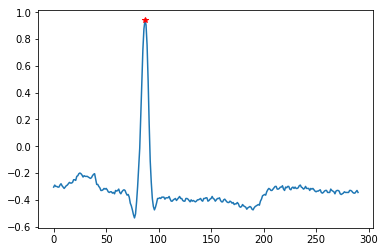

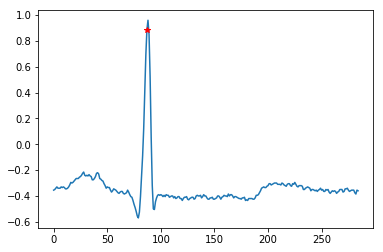

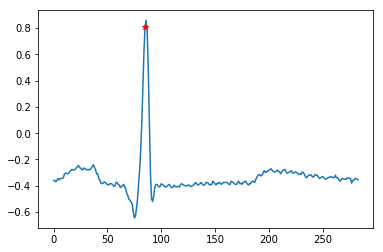

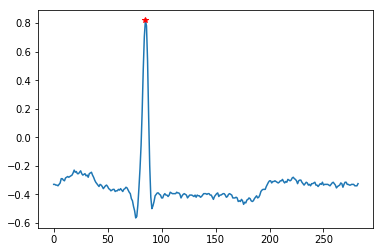

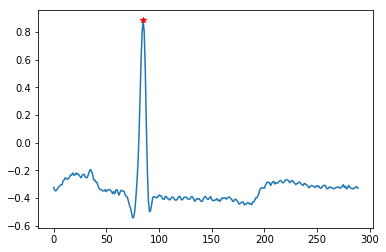

In [2]:
# Normal beats
n_beats, n_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table, wanted_type='N')
for i in range(5):
    plt.figure()
    plt.plot(n_beats[i])
    plt.plot(n_centers[i], n_beats[i][n_centers[i]], 'r*')
    plt.show()

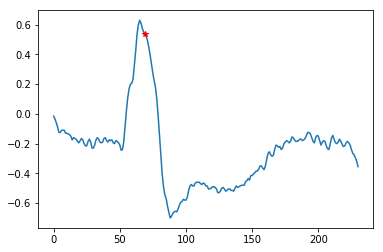

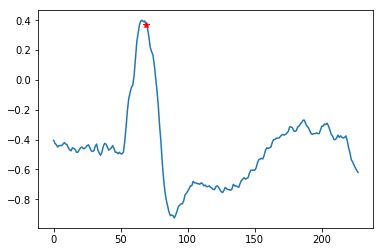

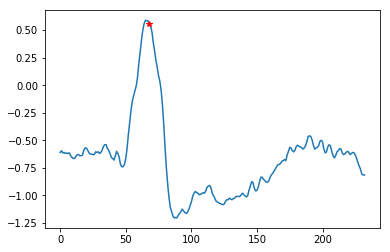

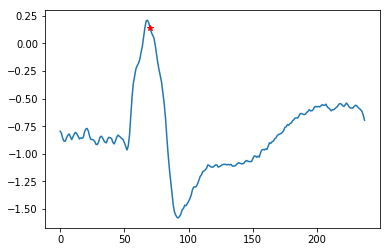

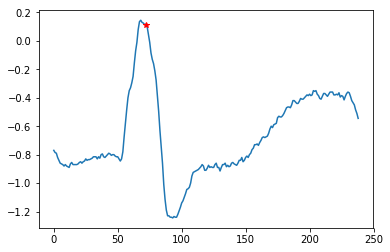

In [3]:
# Left bundle branch block beats
l_beats, l_centers = get_beat_bank(data_dir=data_dir, beat_table=beat_table, wanted_type='L')
for i in range(5):
    plt.figure()
    plt.plot(l_beats[i])
    plt.plot(l_centers[i], l_beats[i][l_centers[i]], 'r*')
    plt.show()

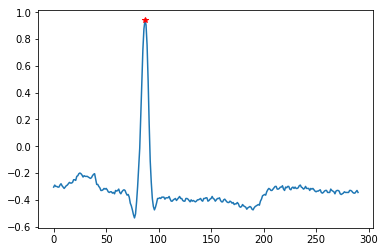

In [4]:
for i in range(1):
    plt.figure()
    plt.plot(n_beats[i])
    plt.plot(n_centers[i], n_beats[i][n_centers[i]], 'r*')
    plt.show()

In [5]:
sig, qrs_p = n_beats[0], n_centers[0]

In [48]:
def right_indicator(env, env_p, W):
    """
    Given the windowed envelop signal env(t), and its peak env_p,
    compute the indicator function:
    A(t) = integral[t-W, t] [env(T) − env(t)]dT
    for the right segment of the envelope peak
    """
    # First check that the window doesn't overlap past the signal start
    # from the envelope peak
    i00 = env_p + 1 - W
    if i00 < 0:
        raise Exception('Window too large')
    
    a = np.zeros(len(env))
    
    # We only calculate a for values right of the envelope peak
    for t in range(env_p+1, len(env)):
        i0 = t - W
        a[t] = np.sum(env[i0:t]) - (env[t] * W)
        # a[t] = np.sum((env(T) - env(t)) for T in range(max(0, t-W), t))
        
    return a


def left_indicator(env, env_p, W):
    """
    Given the windowed envelop signal env(t), and its peak env_p,
    compute the indicator function:
    A(t) = integral[t, t+W] [env(T) − env(t)]dT
    for the left segment of the envelope peak
    """
    # First check that the window doesn't overlap past the signal end
    # from the envelope peak. Otherwise pad the signal to the right
    i11 = env_p - 1 + W
    overlap_len = i11 - len(env)
    if overlap_len > 0:
        env = np.append(env, np.repeat(env[-1], overlap_len))
    
    a = np.zeros(len(env))
    
    # We only calculate a for values left of the envelope peak
    for t in range(env_p-1):
        i1 = t + W
        a[t] = np.sum(env[t:i1]) - (env[t] * W)
        
    return a

def segment_beat(sig, qrs_p, fs=360, qrs_win_0=0.3, qrs_win_1=0.15,
                 max_qrs_duration=0.2):
    """
    Segment qrs_0 qrs_1
    
    Parameters
    ----------
    sig : the ecg beat signal
    qrs_p : the qrs peak index
    fs : sampling frequency of the signal
    qrs_win_0 : the search window for qrs onset, left of the peak
    qrs_win_1 : the search window for qrs offset, right of the peak
    max_qrs_t : maximum possible qrs time in seconds
    
    """
    sig_len = len(sig)
    
    # Filter the signal
    sig_f = bandpass(sig=sig, fs=fs, f_low=0.5, f_high=40, order=4)
    #sig_f = sig
    # Compute the envelope signal
    sig_h = hilbert(sig)
    sig_e = (sig_f**2 + np.abs(sig_h)**2) ** 0.5
    
    # Window the envelope signal based on the max possible qrs width
    # window_len = max_qrs_duration * fs
    
    # Window the envelope signal
    i0 = max(0, qrs_p-int(qrs_win_0*fs))
    i1 = min(qrs_p+int(qrs_win_1*fs), sig_len)
    env = sig_e[i0:i1]
    
    # The peak index of the envelope
    env_p = np.where(env==np.max(env))[0][0]
    
    # Ultimately we want (t2 − tp) < W < (t2 - t1) 
    # The initial W needs to satisfy condition 1 and be larger than qrs1 - qrs_p
    # so half the max qrs duration should be big enough
    W0 = int(max_qrs_duration * fs / 2)
    # a = right_indicator(env=env, env_p=qrs_p-i0, W=W0)
    a = right_indicator(env=env, env_p=env_p, W=W0)
    # Get the point where a is max
    a_max = np.where(a==np.max(a))[0][0]
    
    # The second W should satisfy both conditions.
    # Set it to be a_max - env_p
    W1 = a_max - env_p
    a = right_indicator(env=env, env_p=env_p, W=W1)
    # This time, we take the location where the indicator is max
    # to be the final answer (adjust to start of full signal)
    qrs_1 = np.where(a==np.max(a))[0][0] + i0
    
    # Now do the left. Bigger starting window.
    W0 = int(max_qrs_duration * fs * 1)
    a = left_indicator(env=env, env_p=env_p, W=W0)
    a_max = np.where(a==np.max(a))[0][0]
    W1 = env_p - a_max
    a = left_indicator(env=env, env_p=env_p, W=W1)
    qrs_0 = np.where(a==np.max(a))[0][0]
    
    # Compute the 
    
    
    return sig_f, sig_h, sig_e, env, qrs_0, qrs_1

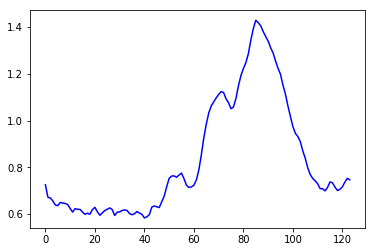

In [29]:
plt.figure()
plt.plot(env, 'b')
plt.show()

0


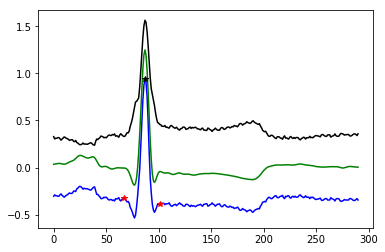

1


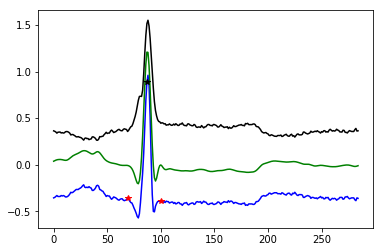

2


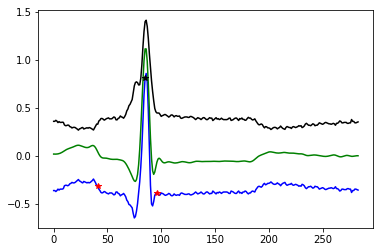

3


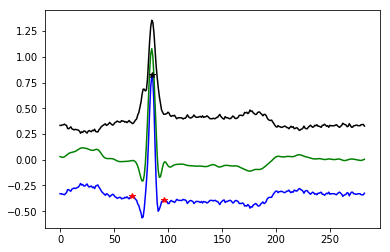

4


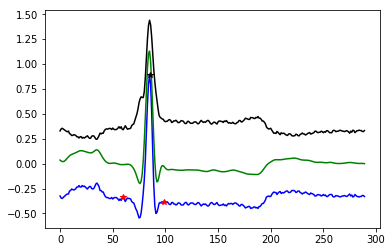

5


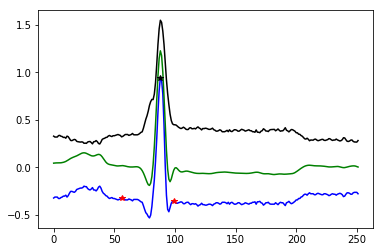

6


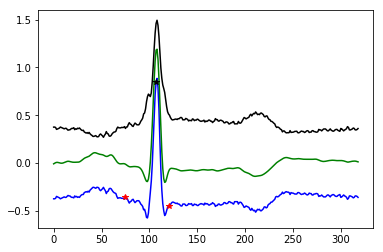

7


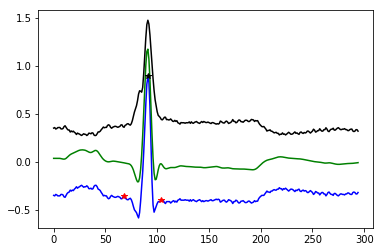

8


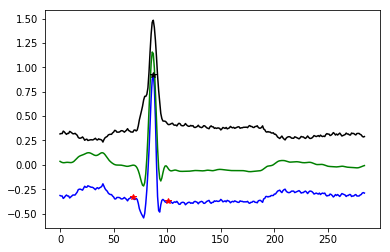

9


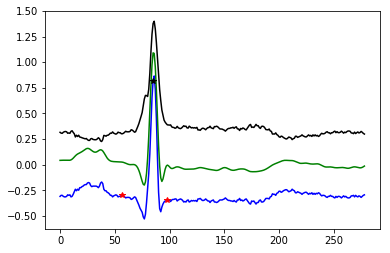

In [51]:
# Normal Beats
for i in range(10):
    print(i)
    s, p = n_beats[i], n_centers[i]
    sig_f, sig_h, sig_e, env, qrs_0, qrs_1 = segment_beat(s, p, fs=360, max_qrs_duration=0.2)
    plt.figure()
    plt.plot(s, 'b')
    plt.plot(sig_f, 'g')
    plt.plot(sig_e, 'k')
    plt.plot(p, s[p], 'k*')
    plt.plot(qrs_0, s[qrs_0], 'r*')
    plt.plot(qrs_1, s[qrs_1], 'r*')
    plt.show()
    # 2 3 9 early, 6 late for normal

0


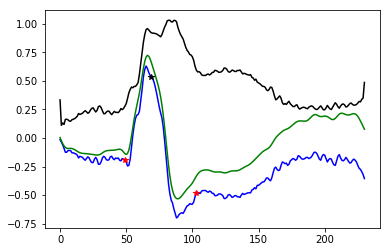

1


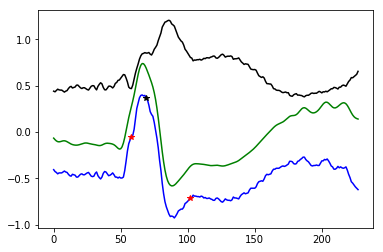

2


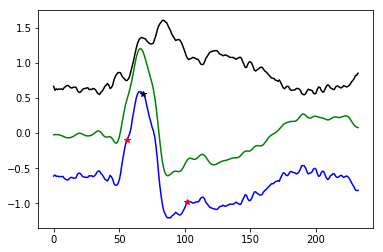

3


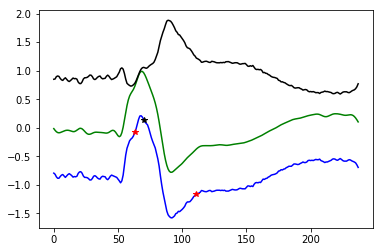

4


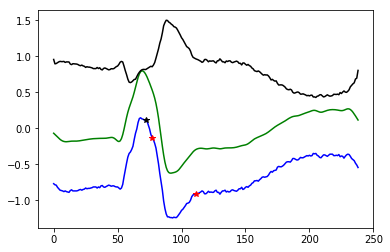

5


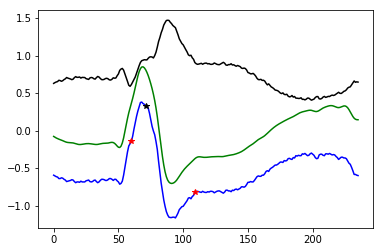

6


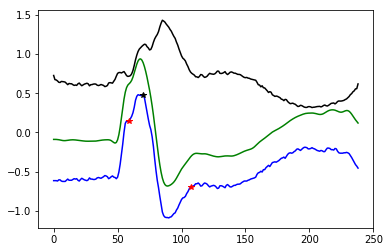

7


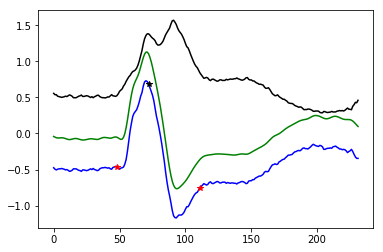

8


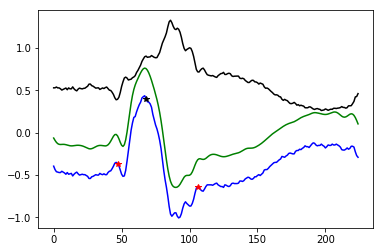

9


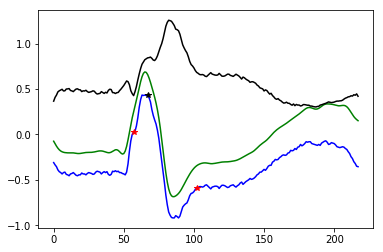

In [75]:
# L beats
# Problem: The hilbert transform is not a good envelope function for 
# bundle branch block
for i in range(10):
    print(i)
    s, p = l_beats[i], l_centers[i]
    sig_f, sig_h, sig_e, env, qrs_0, qrs_1 = segment_beat(s, p, fs=360, max_qrs_duration=0.2)
    plt.figure()
    plt.plot(s, 'b')
    plt.plot(sig_f, 'g')
    plt.plot(sig_e, 'k')
    plt.plot(p, s[p], 'k*')
    plt.plot(qrs_0, s[qrs_0], 'r*')
    plt.plot(qrs_1, s[qrs_1], 'r*')
    plt.show()

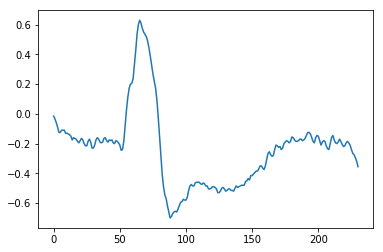

In [71]:
plt.plot(l_beats[0])
plt.show()

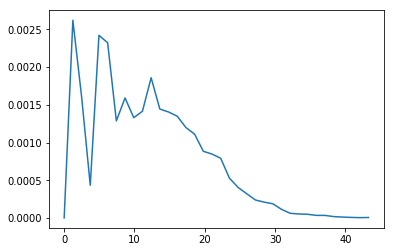

In [69]:
f, pxx = periodogram(n_beats[0], fs=360)
plt.figure()
plt.plot(f[:int(len(f)/4)], pxx[:int(len(f)/4)])
plt.show()

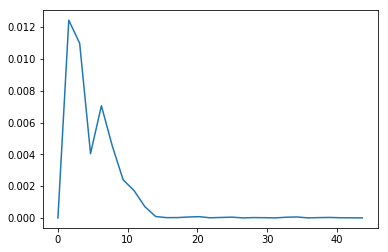

In [70]:
f, pxx = periodogram(l_beats[0], fs=360)
plt.figure()
plt.plot(f[:int(len(f)/4)], pxx[:int(len(f)/4)])
plt.show()

In [ ]:
w0 = np.array([0, 1, 2, 3, 4, 5, 6, 5, 4, 3])
w1 = np.array([0, -1, -2, -3, -4, -5, -6, -5, -4, -3])

In [ ]:
# Flat, concave, convex
def is_convex()



In [177]:
# OLD
# sig_smooth = signal.filtfilt(b=[1] * 10, a=[1], x=sig) / 40
analytic_signal = signal.hilbert(sig)

amplitude_envelope = np.abs(analytic_signal)

def segment_beat(sig, qrs_ind, fs=360, max_qrs_duration=0.2):
    """
    Segment a single heartbeat, given the signal and its qrs index
    """
    # Moving average samples
    
    
    ma_samps = 10
    sig = signal.filtfilt(b=[1] * ma_samps, a=[1], x=sig)
    
    # Isolate the qrs complex
    max_qrs_width = int(max_qrs_duration * fs)
    h_max_qrs_width = max_qrs_width // 2
    
    dy = np.diff(sig)
    abs_dy = dy ** 2
    
    print(max_qrs_width, h_max_qrs_width)
    # Crawl left and right until the moving average gradient remains relatively flat
    # Left
    for i in range(qrs_ind, qrs_ind-h_max_qrs_width, -1):
        ma_gradient_l = np.mean(abs_dy[i-ma_samps:i])
        ma_gradient_r = np.mean(abs_dy[i+1:i+1+ma_samps])
        print(i, ma_gradient_l, ma_gradient_r, ma_gradient_l / ma_gradient_r)
        if (ma_gradient_l / ma_gradient_r) < 0.05:
            qrs_lim_0 = i
            break
    # Didn't manage to find limit
    else:
        print('dah')
        qrs_lim_0 = qrs_ind - h_max_qrs_width
    
    print('\n\n Moving right \n\n')
    # Right
    ma_gradient_prev = np.mean(abs_dy[qrs_ind-h_max_qrs_width:qrs_ind+h_max_qrs_width])
    for i in range(qrs_ind, qrs_ind+h_max_qrs_width):
        ma_gradient_current = np.mean(abs_dy[i:i+ma_samps])
        print(ma_gradient_current, ma_gradient_prev, ma_gradient_current / ma_gradient_prev)
        if ma_gradient_current < ma_gradient_prev * .15:
            qrs_lim_1 = i
            break
        ma_gradient_prev = ma_gradient_current
    # Didn't manage to find limit
    else:
        print('doh')
        qrs_lim_1 = qrs_ind + h_max_qrs_width

    # Assume the 
    
    
    # Figure out whether the qrs complex points up or down
    
    return qrs_lim_0, qrs_lim_1

In [172]:
qrs_lim_0, qrs_lim_1 = segment_beat(sig, center)

72 36
87 56.61387 55.81943 1.0142323201795505
86 58.3735825 54.4560075 1.0719401803373116
85 57.62708999999999 51.534807500000014 1.1182168479042047
84 53.90896 48.21555000000001 1.1180824443566442
83 47.39116 45.42284000000001 1.0433332658195742
82 38.844212500000005 43.6967525 0.8889496421959504
81 29.4690925 43.25648 0.6812642290819779
80 20.374029999999998 44.035890000000016 0.462668745879781
79 12.635372499999999 46.12505000000001 0.27393731822512923
78 6.923319999999999 49.4120075 0.14011412104638732
77 3.340769999999999 53.25471000000001 0.06273191610657533
76 1.4778074999999986 56.61387 0.02610327645857806


 Moving right 


54.4560075 16.272821875 3.346439106769857
55.81943 54.4560075 1.0250371366281306
54.5743725 55.81943 0.9776949083858435
50.2500725 54.5743725 0.9207631750598689
43.19426 50.2500725 0.8595860234828516
34.54647 43.19426 0.7997930743575651
25.552197500000005 34.54647 0.7396471332671618
17.294677500000002 25.552197500000005 0.6768371878778723
10.574677499999996

In [178]:
# Plot the lims
print(qrs_lim_0, qrs_lim_1)
plt.figure()
plt.plot(sig)
plt.plot(amplitude_envelope, 'k')
plt.plot(qrs_lim_0, sig[qrs_lim_0], 'r*')
plt.plot(qrs_lim_1, sig[qrs_lim_1], 'r*')
plt.plot(dy)
plt.plot(abs_dy)
plt.show()

76 123


99

87

In [19]:
fs = 360
max_qrs_duration = 0.2
max_qrs_len = int(max_qrs_duration * fs)
dy = np.diff(sig)
abs_dy = np.abs(dy)

In [170]:
plt.figure()
plt.plot(sig)
plt.plot(sig_smooth, 'k')
plt.plot(center, sig[center], 'r*')

plt.plot(dy)
plt.plot(abs_dy)
plt.show()

In [16]:
dy = np.diff(sig)

In [153]:
x = np.array([1,2,3]) ** 2

In [154]:
x

array([1, 4, 9])